## XGBoost(eXtra Gradient Boost)

- XGBoost와 부스팅 계열 알고리즘에서 가장 각광을 받고 있음

- XGBoost 보다 학습에 걸리는 시간이 훨씬 적음

### LightGBM의 장점
- XGBoost 대비 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할
    - 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행

### LightGBM의 단점
- 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움
- (공식 문서상 대략 10,000건 이하의 데이터 세트)

### 기존 GBM과의 차이점
- 일반적인 균형트리분할(Level Wise) 방식과 달리 **`리프중심 트리분할(Leaf Wise)`** 방식을 사용

- 균형트리분할은 최대한 균형 잡힌 트리를 유지하며 분할하여 트리의 깊이를 최소화하여 오버피팅에 강한구조이지만 균형을 맞추기 위한 시간이 필요함
- 리프중심 트리분할의 경우 최대 손실 값을 가지는 리프노드를 지속적으로 분할하면서 트리가 깊어지고 비대칭적으로 생성
    - 이로써 예측 오류 손실을 최소화하고자 함
![image.png](attachment:image.png)

**사이킷런의 Estimator를 상속받아 fit(), predict() 기반의 학습과 예측, 사이킷런의 다양한 유틸리티 활용 가능**

## LightGBM 설치
- 아나콘다를 통해 설치
- 윈도우에 설치할 경우 Visual Studio tool 2015 이상이 먼저 설치되어 있어야 함
    - https://visualstudio.microsoft.com/ko/downloads/
![image-2.png](attachment:image-2.png)

- 아나콘다 프롬프트를 관리자 권한으로 실행한 후 conda 명령어 수행

**`conda install -c conda-forge lightgbm`**
![image.png](attachment:image.png)


In [1]:
import xgboost
xgboost.__version__

'1.3.3'

### LightGBM 하이퍼파라미터

- XGBoost와 매우 유사함
- 유의할 점 :
    - 리프 노드가 계속 분할하면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요

![image.png](attachment:image.png)

### 하이퍼 파라미터 튜닝 방안

**[방안1] num_leaves 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것**

- num_leaves는 개별 트리가 가질 수 있는 최대 리프 개수로 LightGBM 모델 복잡도를 제어하는 주요 파라미터
    - num_leaves 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 영향도가 커짐


- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 변경됨
    - 과적합을 개선하기 위한 중요한 파라미터
    - num_leaves와 학습 데이터의 크기에 따라 달라지지만 보통 큰 값으로 설정하면 트리가 깊어짐을 방지함


- max_depth는 명시적으로 깊이의 크기를 제한함
    - num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용


**[방안2] learning_rate를 작게 하면서 n_estimations를 크게 하는 것**
- n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있으므로 주의



**[방안3] 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용**


**[방안4] 학습 데이터에 사용할 피처 수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용하는 것도 과적합 제어 방안**





## 파이썬 래퍼 LightGBM, 사이킷런 래퍼 XGBoost, LightGBM 하이퍼파라미터 비교
![image.png](attachment:image.png)

## LightGBM 적용한 위스콘신 유방암 예측

### LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트

In [3]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

In [5]:
cancer_df = pd.DataFrame(data=X_features,columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [7]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,
                                                 test_size=0.2,random_state=156)

print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [10]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest  = xgb.DMatrix(data=X_test,label=y_test)

In [11]:
params={'max_depth':3,'eta':0.1,'objective':'binary:logistic','eval_metric':'logloss'}
num_rounds = 400

In [12]:
wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params=params, dtrain=dtrain,
                      num_boost_round=num_rounds,
                      early_stopping_rounds=100,evals=wlist)

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

In [15]:
pred_probs = xgb_model.predict(dtest)
print('predict()')
print(np.round(pred_probs[:10],3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시',preds[:10])

predict()
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, predr_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [17]:
get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

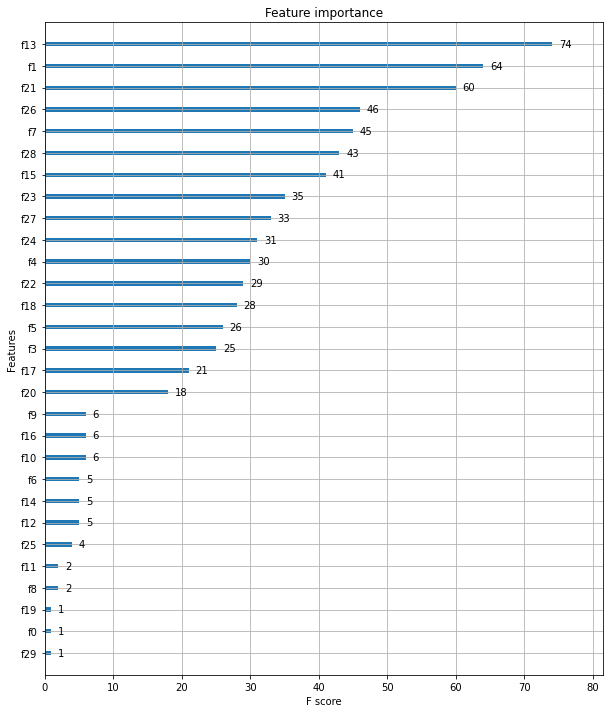

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [19]:
ax

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

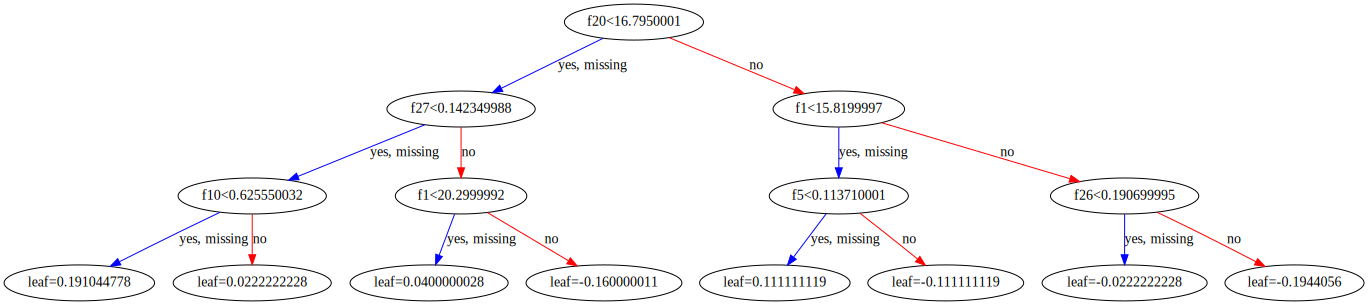

In [20]:
from sklearn.tree import export_graphviz
xgboost.to_graphviz(xgb_model,zise='8,8')

In [23]:
from xgboost import XGBClassifier

evals=[(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)

xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=400,eval_set=evals,
               eval_metric='logloss',verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [24]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [26]:
from xgboost import XGBClassifier

evals=[(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)

xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_set=evals,
               eval_metric='logloss',verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [27]:
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [29]:
from xgboost import XGBClassifier

evals=[(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)

xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,eval_set=evals,
               eval_metric='logloss',verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [30]:
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9947


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

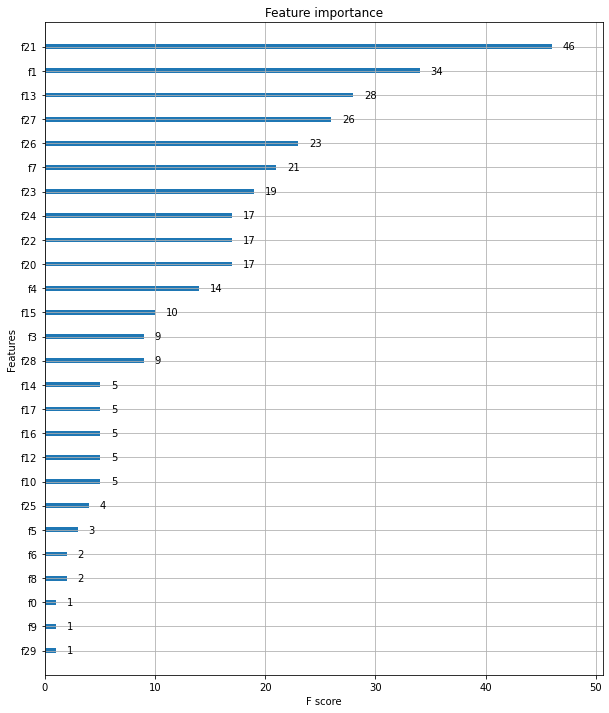

In [34]:
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)